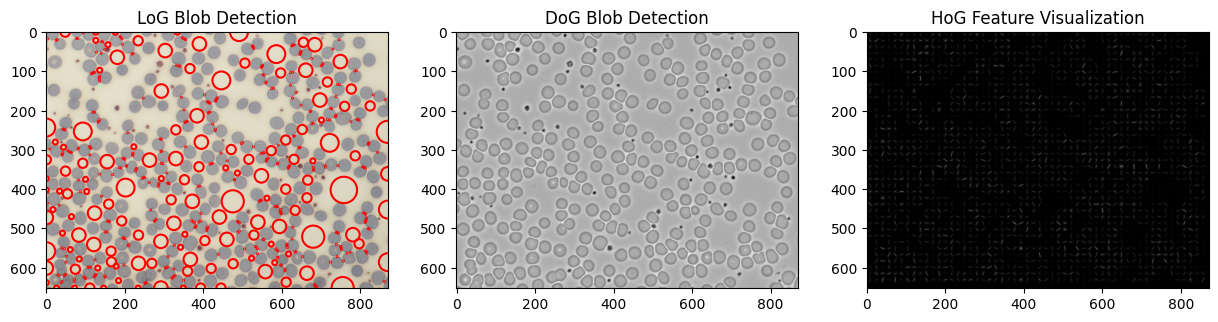

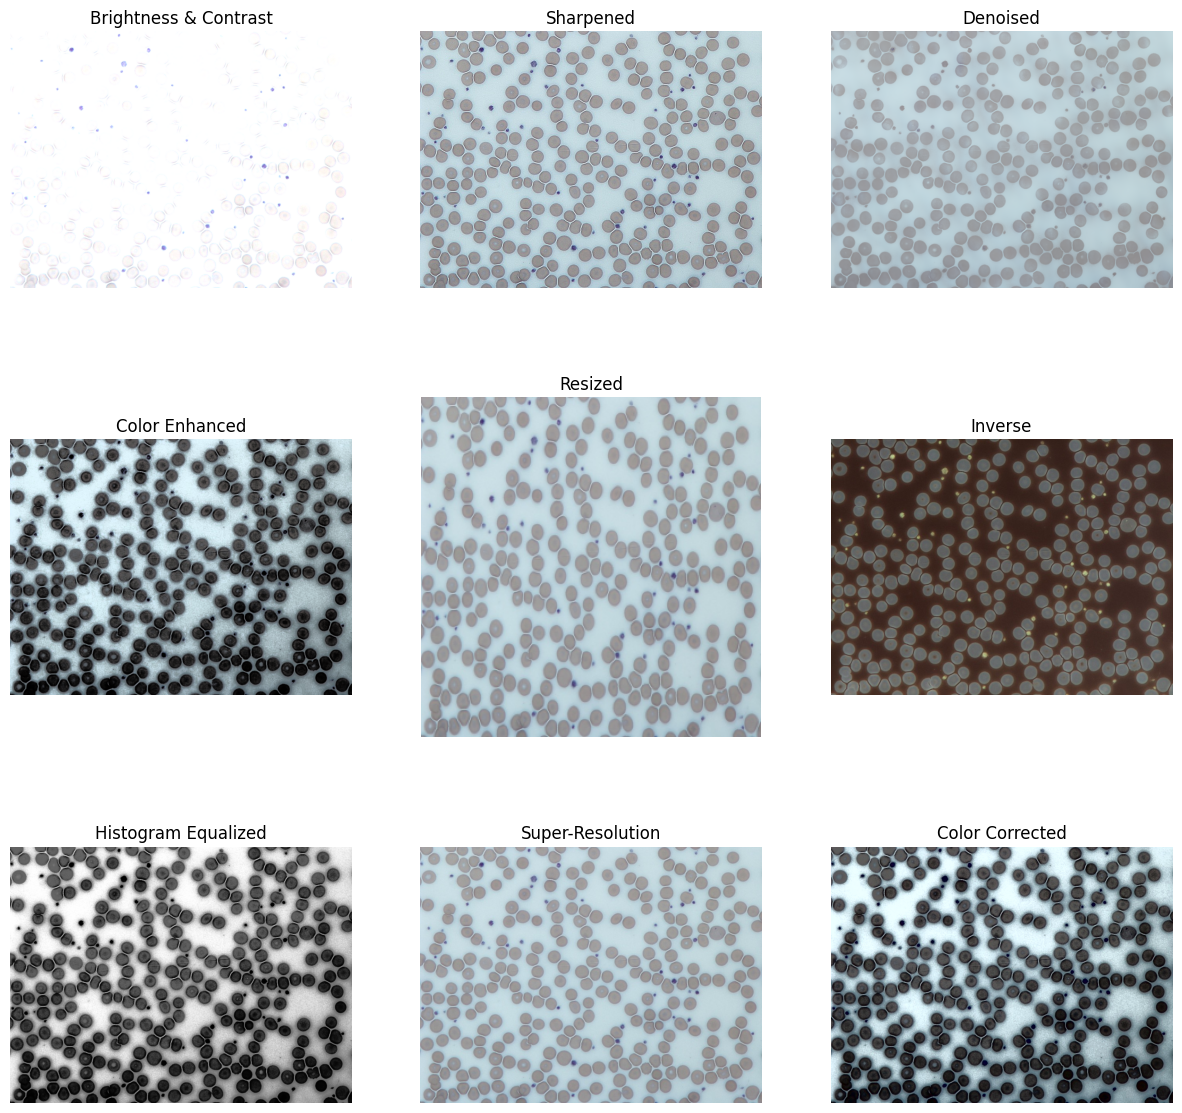

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.filters import difference_of_gaussians
from skimage.feature import hog
from skimage import exposure
from skimage.restoration import denoise_bilateral
from skimage.transform import rescale, resize
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist

image = cv2.imread("C://Users//Anika Sharma//Desktop//computer vision//labs//microscope_image.jpg")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### BLOB DETECTION TECHNIQUES ###
# 1. LoG (Laplacian of Gaussian)
blobs_log = blob_log(rgb2gray(image), min_sigma=1, max_sigma=50, num_sigma=10, threshold=0.1)

# 2. DoG (Difference of Gaussian)
dog_image = difference_of_gaussians(image_gray, low_sigma=1, high_sigma=5)

# 3. HoG (Histogram of Oriented Gradients)
fd, hog_image = hog(image_gray, orientations=8, pixels_per_cell=(16, 16),
                     cells_per_block=(1, 1), visualize=True)

# Plot Blob Detection Results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
for blob in blobs_log:
    y, x, r = blob
    axes[0].add_patch(plt.Circle((x, y), r, color='red', linewidth=1.5, fill=False))
axes[0].set_title("LoG Blob Detection")

axes[1].imshow(dog_image, cmap='gray')
axes[1].set_title("DoG Blob Detection")

axes[2].imshow(hog_image, cmap='gray')
axes[2].set_title("HoG Feature Visualization")

plt.show()

### IMAGE QUALITY ENHANCEMENT ###
# 1. Adjusting Brightness and Contrast
bright_contrast_img = cv2.convertScaleAbs(image, alpha=1.5, beta=30)

# 2. Sharpening Image
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened_img = cv2.filter2D(image, -1, kernel)

# 3. Noise Removal (Bilateral Filtering)
denoised_img = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, channel_axis=-1)
denoised_img = img_as_ubyte(denoised_img)

# 4. Enhancing Color
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])
color_enhanced_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# 5. Image Resizing
resized_img = resize(image, (300, 300))
resized_img = img_as_ubyte(resized_img)

# 6. Inverse Transform
inverse_img = cv2.bitwise_not(image)

# 7. Histogram Equalization
equalized_img = cv2.equalizeHist(image_gray)

# 8. Super-resolution using Bicubic Interpolation
super_res_img = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# 9. Color Correction (White Balancing)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
l = cv2.equalizeHist(l)
lab = cv2.merge((l, a, b))
color_corrected_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

# Display Enhanced Images
images = [bright_contrast_img, sharpened_img, denoised_img, color_enhanced_img,
          resized_img, inverse_img, equalized_img, super_res_img, color_corrected_img]
titles = ["Brightness & Contrast", "Sharpened", "Denoised", "Color Enhanced",
          "Resized", "Inverse", "Histogram Equalized", "Super-Resolution", "Color Corrected"]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()
for i in range(len(images)):
    axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axes[i].set_title(titles[i])
    axes[i].axis("off")
plt.show()

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from scipy.ndimage import gaussian_filter, map_coordinates

# GPU Memory Limit Fix
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load MNIST Dataset
def load_mnist():
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train = x_train[..., np.newaxis]  # Reshape to (28,28,1)
    x_test = x_test[..., np.newaxis]
    return x_train, y_train, x_test, y_test

# Apply Elastic Deformation
def elastic_transform(image, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    return map_coordinates(image, indices, order=1).reshape(shape)

# Few-Shot Task Sampling (Reduced batch size)
def create_few_shot_task(x, y, num_classes=3, num_support=3, num_query=3):
    class_indices = np.random.choice(np.unique(y), num_classes, replace=False)
    support, query, labels = [], [], []
    for i, cls in enumerate(class_indices):
        cls_indices = np.where(y == cls)[0]
        selected = np.random.choice(cls_indices, num_support + num_query, replace=False)
        support.append(x[selected[:num_support]])
        query.append(x[selected[num_support:]])
        labels.append(np.full(num_query, i))
    return np.array(support), np.array(query), np.array(labels).flatten()

# Build Prototypical Network
def build_prototypical_network():
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
    ])
    return model

# Train Prototypical Network (Using predict_on_batch)
def train_prototypical_network(model, x_train, y_train, epochs=5):
    for epoch in range(epochs):
        support, query, labels = create_few_shot_task(x_train, y_train)
        support = tf.reshape(support, (-1, 28, 28, 1))
        query = tf.reshape(query, (-1, 28, 28, 1))
        support_embeddings = model.predict_on_batch(support)
        query_embeddings = model.predict_on_batch(query)
        distances = tf.norm(query_embeddings[:, None, :] - support_embeddings[None, :, :], axis=-1)
        predictions = tf.argmin(distances, axis=1)
        accuracy = tf.reduce_mean(tf.cast(predictions == labels, tf.float32))
        print(f"Epoch {epoch + 1}: Accuracy = {accuracy.numpy():.4f}")

# Build Siamese Network
def build_siamese_network():
    base_model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
    ])
    input_a = keras.Input(shape=(28, 28, 1))
    input_b = keras.Input(shape=(28, 28, 1))
    embedding_a = base_model(input_a)
    embedding_b = base_model(input_b)
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([embedding_a, embedding_b])
    output = layers.Dense(1, activation='sigmoid')(distance)
    return keras.Model([input_a, input_b], output)

# Train Siamese Network (Using predict_on_batch)
def train_siamese_network(model, x_train, y_train, epochs=5):
    optimizer = keras.optimizers.Adam()
    loss_fn = keras.losses.BinaryCrossentropy()
    for epoch in range(epochs):
        idx = np.random.choice(len(x_train), 2 * len(x_train), replace=True)
        pairs = [(x_train[i], x_train[j]) for i, j in zip(idx[:len(x_train)], idx[len(x_train):])]
        labels = np.array([1 if y_train[i] == y_train[j] else 0 for i, j in zip(idx[:len(x_train)], idx[len(x_train):])])
        pairs = (np.array([p[0] for p in pairs]), np.array([p[1] for p in pairs]))
        with tf.GradientTape() as tape:
            preds = model(pairs, training=True)
            loss = loss_fn(labels, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        print(f"Epoch {epoch + 1}: Loss = {loss.numpy():.4f}")

# Load and Preprocess Data
x_train, y_train, x_test, y_test = load_mnist()

# Train Prototypical Network
proto_model = build_prototypical_network()
train_prototypical_network(proto_model, x_train, y_train)

# Train Siamese Network
siamese_model = build_siamese_network()
train_siamese_network(siamese_model, x_train, y_train)

print("Meta-Learning Implementation Completed!")


c:\Users\Anika Sharma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: Accuracy = 0.1111
Epoch 2: Accuracy = 0.4444
Epoch 3: Accuracy = 0.1111
Epoch 4: Accuracy = 0.1111
Epoch 5: Accuracy = 0.1111



ResourceExhaustedError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[60000,26,26,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:BiasAdd] name: [0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(60000, 28, 28, 1), dtype=float32)